In [2]:
from typing import Literal, Union, List, Annotated
from typing_extensions import TypedDict
from functions import inference
from templates import *
import json

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain.tools import BaseTool, StructuredTool, tool
from langchain_openai import ChatOpenAI
from templates import template_orig
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

In [3]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

In [4]:
'''
用gpt对比两个题目是否相似或者一样
'''

async def compare(q1: str, q2: str) -> int:
    response = await inference({"question1": q1, "question2": q2}, compare_template)
    # print(response)
    return int(response)

await compare("用红、黄、蓝、紫四种颜色的笔涂下面的四个圆圈，而且四个圆圈的颜色都不一样，共有几种涂法？", "用红、黄、蓝、紫四种颜色的笔涂下面的四个圆圈，而且四个圆圈的颜色都不一样，共有几种涂法？")

executing
10

10

In [5]:
with open("questions_explanation.json", 'r') as file:
    similar_questions = json.load(file)
similar_questions[0]

{'original_question': '用红、黄、蓝、紫四种颜色的笔涂下面的四个圆圈，而且四个圆圈的颜色都不一样，共有几种涂法？',
 'original_explanation': '这道题目要求我们用红、黄、蓝、紫四种颜色的笔涂四个圆圈，并且每个圆圈的颜色都不一样。我们可以通过排列组合的方法来解决这个问题。\n\n首先，我们考虑第一个圆圈的颜色。因为有四种颜色可以选择，所以第一个圆圈有4种选择。\n\n接下来，考虑第二个圆圈的颜色。由于第一个圆圈已经使用了一种颜色，剩下的颜色有3种选择。\n\n然后，考虑第三个圆圈的颜色。此时，前两个圆圈已经使用了两种颜色，剩下的颜色有2种选择。\n\n最后，第四个圆圈的颜色。前三个圆圈已经使用了三种颜色，剩下的颜色只有1种选择。\n\n因此，总共有 \\(4 \\times 3 \\times 2 \\times 1 = 24\\) 种不同的涂法。',
 'similar_question_1': '用红、黄、蓝、绿四种颜色的笔涂下面的四个方块，而且四个方块的颜色都不一样，共有几种涂法？',
 'similar_explanation_1': '这道题目要求我们用红、黄、蓝、绿四种颜色的笔涂四个方块，并且每个方块的颜色都不一样。我们可以通过排列组合的方法来解决这个问题。\n\n首先，我们考虑第一个方块的颜色。因为有四种颜色可以选择，所以第一个方块有4种选择。\n\n接下来，考虑第二个方块的颜色。由于第一个方块已经使用了一种颜色，剩下的颜色有3种选择。\n\n然后，考虑第三个方块的颜色。此时，前两个方块已经使用了两种颜色，剩下的颜色有2种选择。\n\n最后，第四个方块的颜色。前三个方块已经使用了三种颜色，剩下的颜色只有1种选择。\n\n因此，总共有 \\(4 \\times 3 \\times 2 \\times 1 = 24\\) 种不同的涂法。',
 'similar_question_2': '用红、黄、蓝、紫、绿五种颜色的笔涂下面的五个三角形，而且五个三角形的颜色都不一样，共有几种涂法？',
 'similar_explanation_2': '这道题目要求我们用红、黄、蓝、紫、绿五种颜色的笔涂五个三角形，并且每个三角形的颜色都不一样。我们可以通过排列组合的方法来解决这个问题。'}

In [6]:
'''
先写一个手动判断能否找到相似题目的功能
1.给一个input problem有两种可能的返回类型， 1.返回-1 表示没有找到原题且之前没有相似题目记录。2.返回一个list，里面记录相似题目及讲解
2.如果有相似题目及讲解，用作few shots，给一个更具体的prompt告诉他这一题是相似题，可以用类似思路做
3.如果有完全一样的题目及讲解，可以直接在prompt里告诉模型这就是答案，只需要按照名师讲解来进行讲解即可
'''

async def find_similar(orig_problem: str) -> Union[int, List[dict], str]:
    '''调用similar_api(orig_problem), 判断返回是否有原题或者相似'''
    similar_verified = []
    if len(similar_questions) == 0:
        #没有相似题目
        return -1
    else:
        #有相似题目, 如果是原题，直接返回原题讲解
        for question in similar_questions:
            score = await compare(question['original_question'], orig_problem)
            if score == 10:
                #原题
                return question
            elif score >= 7:
                similar_verified.append(question)

        return similar_verified
    


In [ ]:
problems = await find_similar("用红、黄、蓝、绿四种颜色的笔涂下面的四个方块，而且四个方块的颜色都不一样，共有几种涂法？")
print(problems)

In [7]:
'''
将上面的转化为AI agent的形式
'''
class State(TypedDict):
    messages: Annotated[list, add_messages]

@tool(return_direct=True)
async def find_similar(input_problem: str) -> Union[int, List[dict], str]:
    '''如果这一题目不是常识，调用当前函数以找出数据库中相似的题目，以便更精准的解答题目'''
    print("\n\n\n\n Find similar is called")
    similar_verified = []
    if len(similar_questions) == 0:
        #没有相似题目
        return -1
    else:
        #有相似题目, 如果是原题，直接返回原题讲解
        for question in similar_questions:
            score = await compare(question['original_question'], input_problem)
            if score == 10:
                #原题
                return question
            elif score >= 7:
                similar_verified.append(question)

        return similar_verified

graph_builder = StateGraph(State)
tools = [find_similar]
llm = ChatOpenAI(
    model='gpt-4o',
    temperature=0,
    max_tokens=100,
)
# prompt = PromptTemplate.from_template(template_orig)
llm_with_tools = llm.bind_tools(tools)
# parser = StrOutputParser()
# chain = prompt | llm_with_tools | parser

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

graph = graph_builder.compile()

In [8]:
from typing import Literal, Union, List, Annotated
from typing_extensions import TypedDict
from functions import inference
from templates import *
import json

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain.tools import BaseTool, StructuredTool, tool
from langchain_openai import ChatOpenAI
from templates import template_orig
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

In [ ]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

In [ ]:
'''
用gpt对比两个题目是否相似或者一样
'''

async def compare(q1: str, q2: str) -> int:
    response = await inference({"question1": q1, "question2": q2}, compare_template)
    # print(response)
    return int(response)

await compare("用红、黄、蓝、紫四种颜色的笔涂下面的四个圆圈，而且四个圆圈的颜色都不一样，共有几种涂法？", "用红、黄、蓝、紫四种颜色的笔涂下面的四个圆圈，而且四个圆圈的颜色都不一样，共有几种涂法？")

In [ ]:
with open("questions_explanation.json", 'r') as file:
    similar_questions = json.load(file)
similar_questions[0]

In [9]:
'''
先写一个手动判断能否找到相似题目的功能
1.给一个input problem有两种可能的返回类型， 1.返回-1 表示没有找到原题且之前没有相似题目记录。2.返回一个list，里面记录相似题目及讲解
2.如果有相似题目及讲解，用作few shots，给一个更具体的prompt告诉他这一题是相似题，可以用类似思路做
3.如果有完全一样的题目及讲解，可以直接在prompt里告诉模型这就是答案，只需要按照名师讲解来进行讲解即可
'''

async def find_similar(orig_problem: str) -> Union[int, List[dict], str]:
    '''调用similar_api(orig_problem), 判断返回是否有原题或者相似'''
    similar_verified = []
    if len(similar_questions) == 0:
        #没有相似题目
        return -1
    else:
        #有相似题目, 如果是原题，直接返回原题讲解
        for question in similar_questions:
            score = await compare(question['original_question'], orig_problem)
            if score == 10:
                #原题
                return question
            elif score >= 7:
                similar_verified.append(question)

        return similar_verified
    


In [10]:
problems = await find_similar("用红、黄、蓝、绿四种颜色的笔涂下面的四个方块，而且四个方块的颜色都不一样，共有几种涂法？")
print(problems)

executing
7executing
3executing
1[{'original_question': '用红、黄、蓝、紫四种颜色的笔涂下面的四个圆圈，而且四个圆圈的颜色都不一样，共有几种涂法？', 'original_explanation': '这道题目要求我们用红、黄、蓝、紫四种颜色的笔涂四个圆圈，并且每个圆圈的颜色都不一样。我们可以通过排列组合的方法来解决这个问题。\n\n首先，我们考虑第一个圆圈的颜色。因为有四种颜色可以选择，所以第一个圆圈有4种选择。\n\n接下来，考虑第二个圆圈的颜色。由于第一个圆圈已经使用了一种颜色，剩下的颜色有3种选择。\n\n然后，考虑第三个圆圈的颜色。此时，前两个圆圈已经使用了两种颜色，剩下的颜色有2种选择。\n\n最后，第四个圆圈的颜色。前三个圆圈已经使用了三种颜色，剩下的颜色只有1种选择。\n\n因此，总共有 \\(4 \\times 3 \\times 2 \\times 1 = 24\\) 种不同的涂法。', 'similar_question_1': '用红、黄、蓝、绿四种颜色的笔涂下面的四个方块，而且四个方块的颜色都不一样，共有几种涂法？', 'similar_explanation_1': '这道题目要求我们用红、黄、蓝、绿四种颜色的笔涂四个方块，并且每个方块的颜色都不一样。我们可以通过排列组合的方法来解决这个问题。\n\n首先，我们考虑第一个方块的颜色。因为有四种颜色可以选择，所以第一个方块有4种选择。\n\n接下来，考虑第二个方块的颜色。由于第一个方块已经使用了一种颜色，剩下的颜色有3种选择。\n\n然后，考虑第三个方块的颜色。此时，前两个方块已经使用了两种颜色，剩下的颜色有2种选择。\n\n最后，第四个方块的颜色。前三个方块已经使用了三种颜色，剩下的颜色只有1种选择。\n\n因此，总共有 \\(4 \\times 3 \\times 2 \\times 1 = 24\\) 种不同的涂法。', 'similar_question_2': '用红、黄、蓝、紫、绿五种颜色的笔涂下面的五个三角形，而且五个三角形的颜色都不一样，共有几种涂法？', 'similar_explanation_2': '这道题目要求我们用红、黄、蓝、紫、绿五种颜色的笔涂五个三角形，并且每个三角形的颜色都不一样。我们可以通过排列组合的

In [11]:
'''
将上面的转化为AI agent的形式
'''
class State(TypedDict):
    messages: Annotated[list, add_messages]

@tool(return_direct=True)
async def find_similar(input_problem: str) -> Union[int, List[dict], str]:
    '''如果这一题目不是常识，调用当前函数以找出数据库中相似的题目，以便更精准的解答题目'''
    print("\n\n\n\n Find similar is called")
    similar_verified = []
    if len(similar_questions) == 0:
        #没有相似题目
        return -1
    else:
        #有相似题目, 如果是原题，直接返回原题讲解
        for question in similar_questions:
            score = await compare(question['original_question'], input_problem)
            if score == 10:
                #原题
                return question
            elif score >= 7:
                similar_verified.append(question)

        return similar_verified

graph_builder = StateGraph(State)
tools = [find_similar]
llm = ChatOpenAI(
    model='gpt-4o',
    temperature=0,
    max_tokens=100,
)
# prompt = PromptTemplate.from_template(template_orig)
llm_with_tools = llm.bind_tools(tools)
# parser = StrOutputParser()
# chain = prompt | llm_with_tools | parser

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

graph = graph_builder.compile()

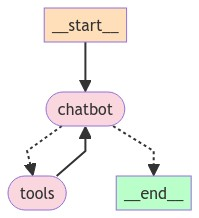

In [12]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [13]:
user_input = "用红、黄、蓝、紫四种颜色的笔涂下面的四个圆圈，而且四个圆圈的颜色都不一样，共有几种涂法？"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
# events = graph.stream(
#     {"messages": [("user", user_input)]}, config, stream_mode="values"
# )
# for event in events:
#     event["messages"][-1].pretty_print()

async for chunk in graph.astream_events({"messages": [("user", user_input)]}, config, version='v2'):
    print(chunk)

/Users/eureka/miniconda3/envs/compute/lib/python3.10/site-packages/langchain_core/_api/beta_decorator.py:87: LangChainBetaWarning: This API is in beta and may change in the future.
  warn_beta(


{'event': 'on_chain_start', 'data': {'input': {'messages': [('user', '用红、黄、蓝、紫四种颜色的笔涂下面的四个圆圈，而且四个圆圈的颜色都不一样，共有几种涂法？')]}}, 'name': 'LangGraph', 'tags': [], 'run_id': 'a8009361-ba52-4178-b52a-ece0cd3ee08d', 'metadata': {'thread_id': '1'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [('user', '用红、黄、蓝、紫四种颜色的笔涂下面的四个圆圈，而且四个圆圈的颜色都不一样，共有几种涂法？')]}}, 'name': '__start__', 'tags': ['graph:step:0', 'langsmith:hidden'], 'run_id': 'e6666ce7-82e4-4640-b35f-18c41b88671e', 'metadata': {'thread_id': '1', 'langgraph_step': 0, 'langgraph_node': '__start__', 'langgraph_triggers': ['__start__'], 'langgraph_task_idx': 0}, 'parent_ids': ['a8009361-ba52-4178-b52a-ece0cd3ee08d']}
{'event': 'on_chain_end', 'data': {'output': {'messages': [('user', '用红、黄、蓝、紫四种颜色的笔涂下面的四个圆圈，而且四个圆圈的颜色都不一样，共有几种涂法？')]}, 'input': {'messages': [('user', '用红、黄、蓝、紫四种颜色的笔涂下面的四个圆圈，而且四个圆圈的颜色都不一样，共有几种涂法？')]}}, 'run_id': 'e6666ce7-82e4-4640-b35f-18c41b88671e', 'name': '__start__', 'tags': ['graph:step:0', 'langsm